In [24]:
import cv2
import pandas as pd
import numpy as np
from tensorflow import keras
import glob
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# 장르 데이터 읽기

---

In [25]:
land_path = '../Data/Artist/genre/resized/landscape/*.jpg'
land_file = [file for file in glob.glob(land_path)]
landCount = len(land_file)
landCount

378

In [26]:
still_path = '../Data/Artist/genre/resized/still life/*.jpg'
still_file = [file for file in glob.glob(still_path)]
stillCount = len(still_file)
stillCount

372

In [27]:
height = 400
width = 600
colors = 3
numberOfimage = landCount + stillCount

In [28]:
trainData = np.zeros(numberOfimage * height * width * colors).reshape(-1, height, width, colors)

In [29]:
targetData = np.concatenate([np.zeros(landCount), np.ones(stillCount)])  # land : 0, still : 1
targetData

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [30]:
i = 0
for id in range(landCount):
    img = np.array(Image.open(land_file[id]), np.int32)
    trainData[i] = img
    i += 1

In [31]:
for id in range(stillCount):
    img = np.array(Image.open(still_file[id]), np.int32)
    trainData[i] = img
    i += 1


---
# 학습, 검증, 테스트 데이터 분리

In [32]:
train = trainData / 255.0

In [33]:
trainData, testData, trainTarget, testTarget = train_test_split(
    train, targetData, test_size=0.2, random_state=42
)

trainData, valData, trainTarget, valTarget = train_test_split(
    trainData, trainTarget, test_size=0.2, random_state=42
)

In [34]:
print(trainData.shape)
print(trainTarget.shape)
print(valData.shape)
print(valTarget.shape)
print(testData.shape)
print(testTarget.shape)

(480, 400, 600, 3)
(480,)
(120, 400, 600, 3)
(120,)
(150, 400, 600, 3)
(150,)


---
# 딥러닝 모델 생성

In [35]:
model = keras.Sequential()

In [36]:
model.add(
    keras.layers.Conv2D(
        64, 
        kernel_size = 3, 
        activation = 'relu',
        padding = 'same',
        input_shape = (height, width, colors) 
    )
)

In [37]:
model.add(keras.layers.MaxPooling2D(2))

In [38]:
model.add(
    keras.layers.Conv2D(
        64, 
        kernel_size = 3, 
        activation = 'relu',
        padding = 'same',
    )
)

In [39]:
model.add(keras.layers.MaxPooling2D(2))

In [40]:
model.add(
    keras.layers.Conv2D(
        128, 
        kernel_size = 3, 
        activation = 'relu',
        padding = 'same',
    )
)

In [41]:
model.add(keras.layers.MaxPooling2D(2))

In [42]:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(200, activation='relu'))
model.add(keras.layers.Dropout(0.7))  # 50% Drop Out
model.add(keras.layers.Dense(200, activation='relu'))
model.add(keras.layers.Dropout(0.7))  # 50% Drop Out
model.add(keras.layers.Dense(2, activation='sigmoid'))

In [43]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 400, 600, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 200, 300, 64)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 200, 300, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 100, 150, 64)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 100, 150, 128)     73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 50, 75, 128)     

In [44]:
# 모델 학습하기
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics ='accuracy'
)

checkpoint_cb = keras.callbacks.ModelCheckpoint("../Data/Artist/model/land_still_v3.h5")
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    trainData, 
    trainTarget, 
    epochs=50, 
    validation_data=[valData, valTarget],
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/50


2022-08-04 15:02:28.335719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - ETA: 0s - loss: 1.7939 - accuracy: 0.5354

2022-08-04 15:02:48.255716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 22s 1s/step - loss: 1.7939 - accuracy: 0.5354 - val_loss: 0.6673 - val_accuracy: 0.6583
Epoch 2/50
15/15 [==============================] - 21s 1s/step - loss: 0.6386 - accuracy: 0.6729 - val_loss: 0.6397 - val_accuracy: 0.6000
Epoch 3/50
15/15 [==============================] - 21s 1s/step - loss: 0.5358 - accuracy: 0.7500 - val_loss: 0.5009 - val_accuracy: 0.7750
Epoch 4/50
15/15 [==============================] - 20s 1s/step - loss: 0.4420 - accuracy: 0.8042 - val_loss: 0.5778 - val_accuracy: 0.7833
Epoch 5/50
15/15 [==============================] - 20s 1s/step - loss: 0.4002 - accuracy: 0.8458 - val_loss: 0.5344 - val_accuracy: 0.7917
Epoch 6/50
15/15 [==============================] - 20s 1s/step - loss: 0.3722 - accuracy: 0.8396 - val_loss: 0.6246 - val_accuracy: 0.7750
Epoch 7/50
15/15 [==============================] - 20s 1s/step - loss: 0.4528 - accuracy: 0.8417 - val_loss: 0.4531 - val_accuracy: 0.7833
Epoch 8/50
15/15 [=============

In [45]:
model.evaluate(testData, testTarget)

5/5 [==============================] - 2s 433ms/step - loss: 0.3670 - accuracy: 0.8600


[0.36699673533439636, 0.8600000143051147]

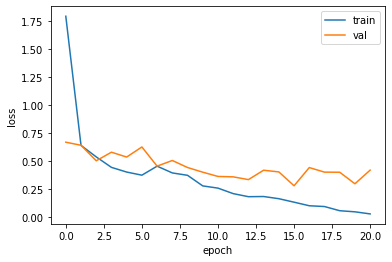

In [46]:
# 시각화 해보기
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()